# 10. 프로젝트: 인물 모드 문제점 찾기
## 인물모드 사진 만드는 순서
1. 배경이 있는 사진을 준비한다. (배경과 사람의 거리가 멀리 있으면 좋음)
2. __Semantic segmentation__ 으로 인물과 배경을 분리한다.
   - DeepLab 알고리즘 사용
3. 세그멘테이션 결과를 원래 크기로 복원한다. 
4. Blurring 기술로 배경을 흐리게 한다.
5. 피사체를 배경의 원래 위치에 합성한다.       
-> 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다.

## 이론
### 1. 아웃포커싱
아웃포커싱은 한국에서만 사용하는 용어이고, 정확한 표현은 __얕은 피사계 심도(shallow depth of field) / 셸로우 포커스(shallow focus)__ 이다. 

### 2. Segmentation
모든 픽셀의 레이블을 예측한다. 
#### 1) Semantic segmentation
사진에 있는 모든 픽셀을 (미리 지정된) class로 분류한다.  
#### 2) Instance segmentation
같은 클래스의 instance를 구별한다.
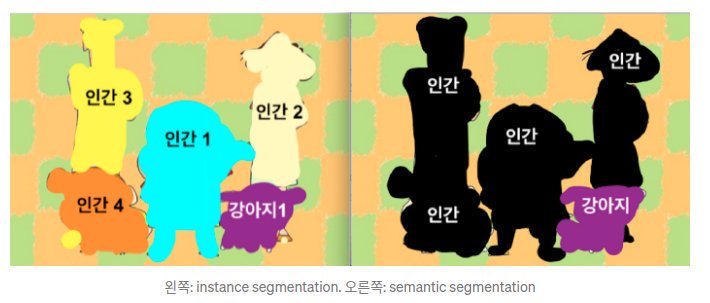
- 위의 내용 참고 및 사진 출처: [1편: Semantic Segmentation 첫걸음!](https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb)

### 3. DeepLab 알고리즘(DeepLab v3+)
세그멘테이션 모델에서 성능이 좋고 많이 사용하는 DeepLab 알고리즘을 사용한다. 자세한 내용은 [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)을 참고한다. 

DeepLab 모델은 구글에서 제공하는 모델 구조를 사용하였다. 

- DeepLab Demo : https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb

구글에서 Tensorflow V1으로 작성한 DeepLab 모델구조를 그대로 가져와 활용하면서, Tensorflow V2에서 V1 코드와 모델구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용한다. (노드 참고)

## Step 1. 인물모드 직접 해 보기
Semantic segmentation을 이용하여 최소 3장 이상의 인물모드 사진을 만들어 본다. 
### 1. 셀카를 이용한 인물모드
#### 1. 배경이 있는 사진을 준비한다. (배경과 사람의 거리가 멀리 있으면 좋음)

In [1]:
# 사용할 패키지 불러오기
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

(1944, 2592, 3)


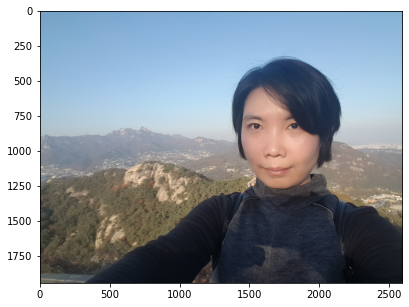

In [2]:
# 이미지 읽기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.figure(figsize=(10,5))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

#### 2. Semantic segmentation 으로 인물과 배경을 분리한다.
DeepLab 모델을 준비한다. 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만든다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
             tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))  
        resized_image = cv2.resize(img_orig, target_size)   # resize
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)  # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
        img_input = resized_rgb
        return img_input
    
    # 세그멘테이션하는 함수
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식 활용
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 받고 DeepLabModel 을 초기화한다. (PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전) 그리고 모델의 사전학습된 가중치를 불러온다.

- 참고:[pretrained weight](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj44/aiffel/human_segmentation/models
model loaded successfully!


준비한 이미지를 네트워크에 입력한다. 

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1944, 2592, 3) (384, 513, 3) 15


원본 이미지 img_orig 의 크기는 1944x2592이고 모델에 맞게 조정된 이미지 img_resized 의 크기는 384x513로 출력된다. ((높이, 너비, 채널) 순서로 표기됨) 물체로 인식된 라벨 중 가장 큰 값 seg_map.max은 15로 출력되었다. 

DeepLab은 PASCAL VOC의 라벨로 학습되었고 제공하는 라벨 종류는 아래와 같다. 따라서 15의 의미는 인식된 라벨 중 가장 큰 값을 가지는 라벨의 종류가 'person'이라는 것을 의미한다. 

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

'person' 라벨 영역을 검출하기 위하여 마스크를 만들고 시각화한다. 

In [12]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
print(img_mask)
print(type(img_mask))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>


In [14]:
img_mask = img_mask.astype(np.uint8)
print(img_mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


- np.where(seg_map == 15, 15, 0)의 뜻     
조건(seg_map == 15)에 맞는 것을 15로 바꾸고 나머지는 0으로 둔다. 예측된 세그멘테이션 이미지(map)은 최대값이 15가 된다. (위의 사진은 이미 최대값이 15이므로 이 부분은 하지 않아도 된다.)  <출처: [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)>

- ndarray.astype(np.unit8)의 뜻    
img_mask를 unit8 타입으로 바꾼다. ```unit8```은 '0부터 255까지의 정수(Unsigned integer (0 to 255))이다.  <출처: [numpy.ndarray.astype](https://numpy.org/doc/stable/reference/generated/numpy.where.html) /
[Data types](https://numpy.org/devdocs/user/basics.types.html)>

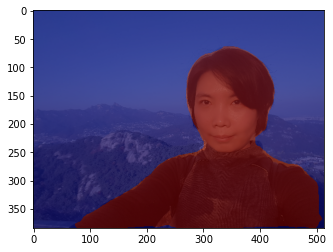

In [16]:
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용


# img_show(가중치 0.6)와 color_mask(가중치 0.35)를 블렌딩
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# 화면 출력 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)) 
plt.show()

- cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)        
'''applyColorMap'''을 사용하여 주어진 이미지에 'Jet colormap'을 적용한다. 
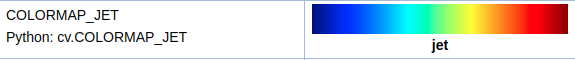
<출처: [ColorMaps in OpenCV](https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html#gga9a805d8262bcbe273f16be9ea2055a65ab3f207661ddf74511b002b1acda5ec09)>


- cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)     
```python
beta = ( 1.0 - alpha );
addWeighted( src1, alpha, src2, beta, 0.0, dst);
```
→ dst=α⋅src1+β⋅src2+γ          
(참고: [Adding (blending) two images using OpenCV](https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html))

#### 3. 세그멘테이션 결과를 원래 크기로 복원한다. 

원본 이미지 크기: (2592, 1944)
마스크의 크기: (384, 513)


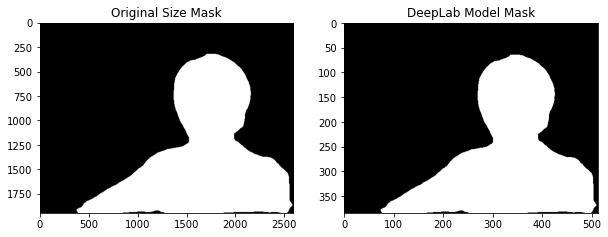

In [17]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'원본 이미지 크기: {img_orig.shape[:2][::-1]}')
print(f'마스크의 크기: {img_mask.shape}')

fig = plt.figure(figsize=(10, 6)) 
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- cv2.resize(img, dsize, fx, fy, interpolation)   
  - dsize: Manual Size. 가로, 세로 형태의 tuple(ex; (100,200))
- 보간법(interpolation)    
이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 픽셀 사이의 값을 채우는 방법이다.
```interpolation = cv.INTER_LINEAR``` : for zooming     
(참고: [opencv-python 문서](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html))

- cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)     
임계값 128 이하의 값은 0으로 임계값 128 이상의 값은 255(최대값)로 만든다. 소스 이미지(img_mask_up)는 grayscale이어야 한다. 

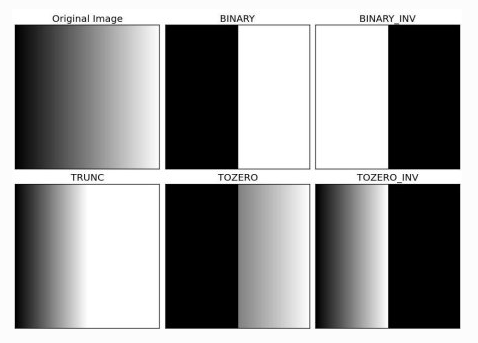
<출처: [Image Thresholding](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)>

#### 4. Blurring 기술로 배경을 흐리게 한다.
1) 이미지 반전 후 배경만 있는 이미지 얻기      
bitwise_not 함수를 이용하여 이미지를 반전시킨다. 즉 배경은 255 사람은 0이 된다. 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 이미지를 얻을 수 있다. 

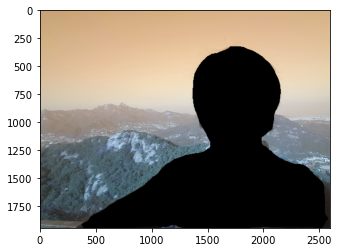

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
 
plt.imshow(img_bg)
plt.show()

- cv2.bitwise_not(img_mask_color) / cv2.bitwise_and(img_orig, img_bg_mask)      
출처: [비트연산](https://copycoding.tistory.com/156)    
두 이미지의 동일한 위치에 대한 연산(0, 1로 연산함)    
  - and: 두 그림 모두 흰색(1)인 부분을 흰색으로 나타냄
  - or: 두 그림 모두 검은색(0)인 부분을 검정색으로 나타냄
  - not: 그림에서 색이 반대로 나타냄(인자가 1개)
  - xor: 두 그림의 값이 서로 같으면 검은색, 같지 않으면 흰색으로 나타냄


2) 이미지 블러(blur) 처리하기 

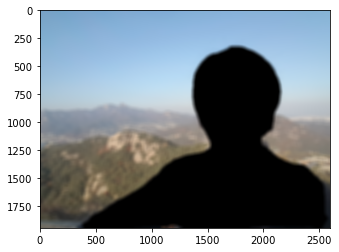

In [19]:
img_bg_blur = cv2.blur(img_bg, (40, 40))

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- cv2.blur(img_bg, (40, 40))    
low-pass filter kernel를 이미지에 적용하여 이미지 블러링을 한다. 노이즈(high frequency content)를 제거하는데 유용하다. 이미지 블러링에는 4가지가 있지만 이곳에서 사용된 것은 'Averaging'으로, a normalized box filter(사이즈: (a, a))를 적용한다. 각 커널 영역의 픽셀의 평균을 각 픽셀에 적용한다. 필터 사이즈의 크기가 클수록 이미지가 더 흐리게 블러링된다.
<참고: [Smoothing Images](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html)>

#### 5. 피사체를 배경의 원래 위치에 합성한다

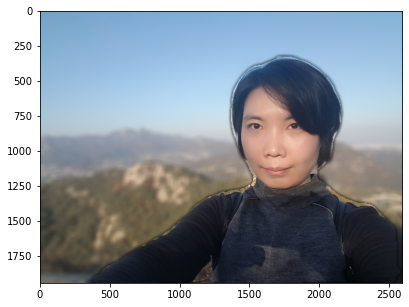

In [20]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.figure(figsize=(10, 5)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2. 크로마키 배경합성

(428, 600, 3)


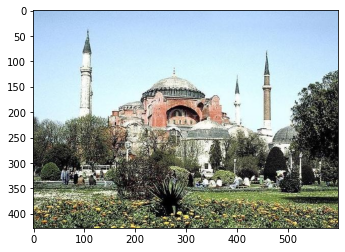

In [21]:
# 이미지 읽기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/S.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_back = cv2.imread(img_path) 
print(img_back.shape)
plt.imshow(cv2.cvtColor(img_back, cv2.COLOR_BGR2RGB))
plt.show()

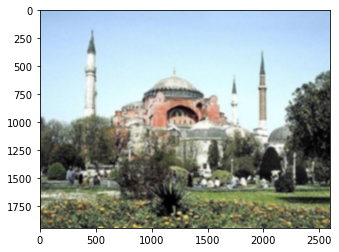

In [22]:
# 배경 사진 사이즈 조절
resize_img = cv2.resize(img_back, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 배경 블러 처리 
img_bg_blur1 = cv2.blur(resize_img, (20,20))
plt.imshow(cv2.cvtColor(img_bg_blur1, cv2.COLOR_BGR2RGB))
plt.show()

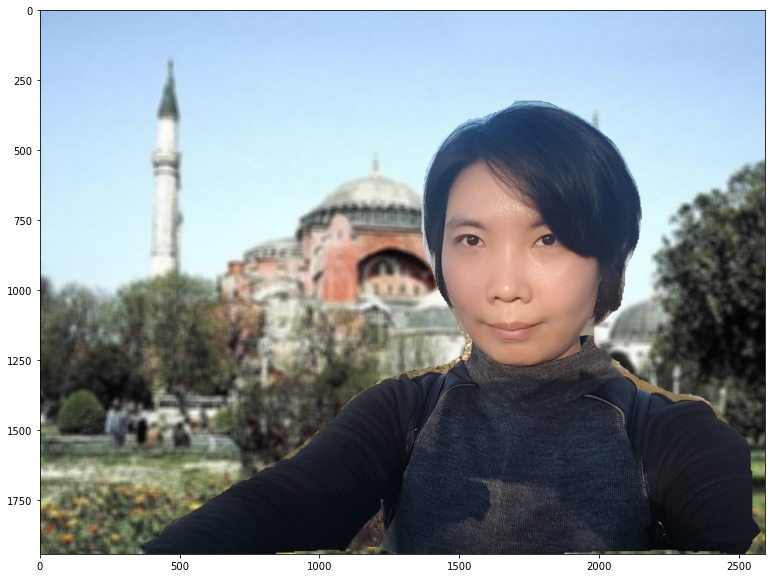

In [23]:
# 새로운 배경과 마스크 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur1)

plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 3. 고양이 아웃포커싱 사진

(485, 862, 3)


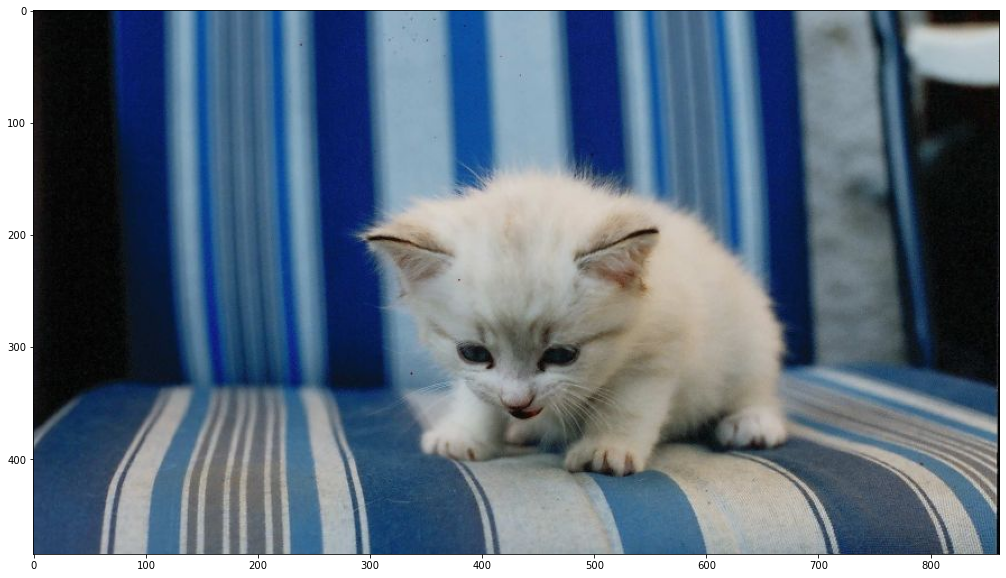

In [70]:
# 이미지 읽기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_cat = cv2.imread(img_path) 
print (img_cat.shape)
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_cat, cv2.COLOR_BGR2RGB))
plt.show()

In [71]:
# 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_cat)
print (img_cat.shape, img_resized.shape, seg_map.max())

(485, 862, 3) (288, 513, 3) 8


LABEL_NAMES에서 cat의 인덱스는 8이다. 

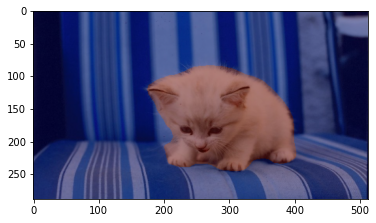

In [72]:
# 마스크를 만들고 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

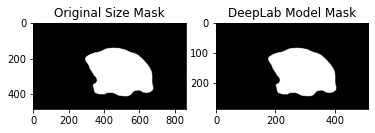

In [73]:
# 세그멘테이션 결과를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_cat .shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

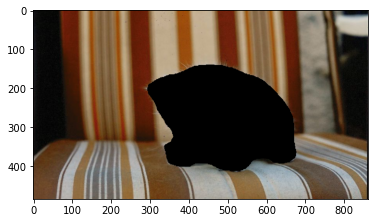

In [74]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_cat, img_bg_mask)
plt.imshow(img_bg)
plt.show()

(145, 348, 3)


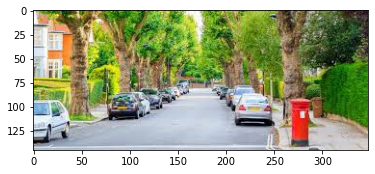

In [75]:
# 이미지 읽기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/f.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_street = cv2.imread(img_path) 
print (img_street.shape)
plt.imshow(cv2.cvtColor(img_street, cv2.COLOR_BGR2RGB))
plt.show()

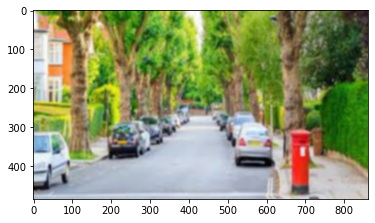

In [76]:
# 배경 사진 사이즈 조절
resize_img1 = cv2.resize(img_street, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

# 배경 블러 처리 
img_bg_blur2 = cv2.blur(resize_img1, (6,6))
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

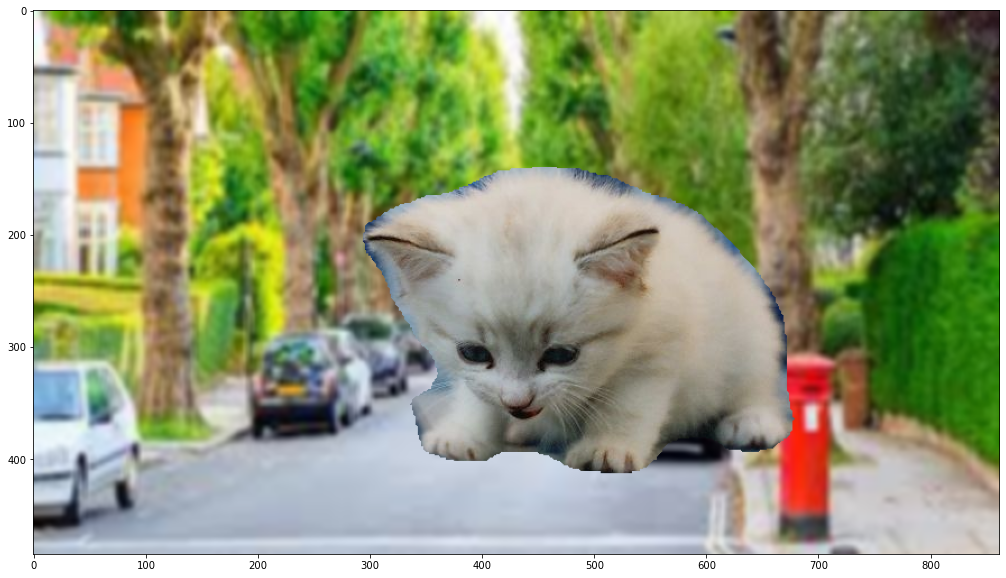

In [77]:
# 새로운 배경과 마스크 합성
img_concat = np.where(img_mask_color==255, img_cat, img_bg_blur2)
plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경에 비해 고양이가 너무 크다. 고양이 이미지의 크기를 줄이려고 시도하였으나 잘 되지 않았다. 

### Step 2. 사진에서 문제점 찾기
#### 1. 노드에 나온 사진의 문제점 찾기
![](https://images.velog.io/images/guide333/post/a91975e6-2894-4e92-a138-33e90667d29f/download.png)

#### 2. 새로운인물 모드 사진의 문제점 찾기
1) 셀카 인물 사진
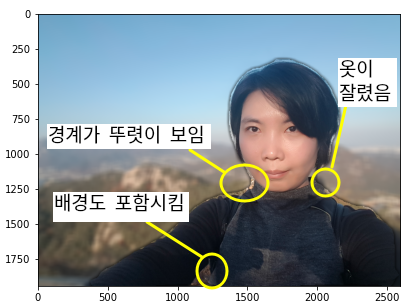
2) 배경 전환 크로마키 사진
![](https://images.velog.io/images/guide333/post/304cc751-64dc-49c0-895f-e5f092f782d5/Screenshot%20from%202021-02-16%2016-28-04.png)
3) 고양이 사진
![](https://images.velog.io/images/guide333/post/6f7762ec-cce9-4597-b402-b4fbe71bde8d/Screenshot%20from%202021-02-16%2016-29-52.png)
4) 다른 사진 
![](https://images.velog.io/images/guide333/post/71f5d25e-f279-4052-9886-9dbc98712e77/Screenshot%20from%202021-02-16%2018-21-43.png)

위에서 나온 문제점을 정리하면,      
1) 경계선이 뚜렷이 보인다.     
2) 마스크가 배경을 포함한다.    
3) 얇거나(털, 수염, 머리카락 등) 어두운 부분(검은 옷, 그림자 등), 다른 객체와 겹치는 부분 등 마스크가 포함시키지 않는 부분이 있다.       

-> 이 현상은 배경이 다를 때 선명하게 보인다.    

### Step 3. 해결 방법을 제안해 보기

아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

#### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

참고자료 : https://ggyul.tistory.com/12

#### 3D Depth Camera 활용하기
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

참고자료 : https://m.blog.naver.com/panoptics/221336152952

#### 깊이 영상(Depth image) 활용하기
하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
참고자료 : https://sites.google.com/view/struct2depth

![](https://images.velog.io/images/guide333/post/dc894390-2bf5-4cd9-b857-eeb5dca2b7ff/Screenshot%20from%202021-02-16%2011-42-49.png)

#### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

참고자료 : https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

### 해결책
1) 경계선이 보이는 문제

경계선이 보이는 문제는 가우시안 블러를 사용하면 된다. 블러는 이미지를 부드럽게 하고, 배경과 원하지 않는 부분을 부드럽게 하여 해당 경계를 찾지 못한다. 프로젝트에서는 평균을 이용한 블러를 사용했지만 가우시안 블러를 사용하면 경계가 보다 매끄럽게 될 수 있다.      
(참조: https://youbidan.tistory.com/19)

2), 3) 배경이 마스크에 포함되거나 인물의 일부가 마스크에 포함되지 않는 문제    

배경을 흐릿하게 하여 피사체를 강조하는 인물 모드는 카메라와 피사체의 거리를 추정하여 가까이 있는 대상에만 초점을 맞추는 것이다. 그러나 프로젝트에서 사용한 사진은 2D이므로 카메라와 피사체의 거리를 추정하기 쉽지 않다. 그래서 마스크가 배경을 포함하거나 피사체의 일부를 마스크에 포함하지 않는 일이 생긴다. 특히 배경이 어둡거나 피사체가 다른 물체와 겹쳐 있으면 피사체가 잘려서 나오는 경우도 있다. 이 문제를 해결하기 위해서 여러 가지 방법을 사용할 수 있다. 

우선 3D Depth camera를 사용할 수 있다. 3D Depth camera는 카메라 2대를 사용하여 픽셀의 깊이를 계산하여 이미지를 재가공한다. 카메라 간 시점 불일치를 이용한 스테레오 방식, 이동 시간 정보를 이용한 ToF(Time-Of-Flight) 방식, 구조화된 빛을 이용한 Structured patter 방식이 있다. 그러나 3D Depth camera는 비용이 많이 들고 사용하지 못할 상황도 자주 발생한다. 

최근에는 딥러닝을 사용하여 카메라 1대로도 카메라와 피사체의 거리를 계산할 수 있는 방식이 개발되었다. Struct2Depth는 "object motion model(객체 모션 모델)"과 "an ego-motion network(자아-모션 네트워크)"을 사용힌 딥러닝으로 개별 객체의 음직임을 예측하여 심도를 예측한다. 이 방식을 사용하면 다음과 같이 segmentation을 개선할 수 있다.

모델:
1. 사전 훈련된 Mask R-CNN을 사용하여 피사체(잠재적으로 움직이는 물체)의 세그멘테이션을 캡쳐한다. 
2. 바이너리 마스크를 사용하여 배경(프레임 -1, 프레임 0, 프레임 +1)에서 피사체를 제거한다. (프레임 -1과 +1은 배경 이미지를 이전과 이후의 이미지로 예측한 이미지이다.)
3. 마스킹한 이미지(배경)를 자아-모션 네트워크로 전송하여 자아-모션 변환 행렬(프레임 -1과 0,  프레임 0과 +1 사이의 변환 매트릭스)을 얻는다. 
4. 자아-모션 변환 행렬을 프레임 -1과 프레임 +1에 적용하여 뒤틀린 프레임 0(뒤틀린 배경)을 얻는다.
5. 자아-모션 변환 행렬을 제거했던 피사체 세그먼트 마스크의 프레임 -1과 +1에 적용한다. 
6. 5를 이용하여 프레임 0에 대한 뒤틀린 세그먼트 마스크를 얻는다. 
7. 바이너리 마스크를 뒤틀린 세그먼트 마스크와 연관된 픽셀을 지키는데 사용한다. 
8. 마스킹된 이미지는 뒤틀린 이미지와 결합되어 예측된 물체의 움직임을 출력하는 물체의 객체 모션 모델로 전달된다.  

모델 사용: 
1. 객체 모션 모델에 의해 피사체를 이동시킨다. 
2. 1의 결과와 뒤틀린 배경을 합친다. 

위의 방식을 사용하면 카메라 1대로도 카메라와 피사체의 거리를 예측하여 배경과 피사체를 정확히 구분할 수 있다. 

마지막으로 구글 pixel4에 장착된 IR 카메라 2대를 통해 카메라와 피사체의 거리를 계산할 수 있다. 그러나 이 프로젝트에서는 카메라 1대를 가지고 아웃포커싱하는 효과를 내는 것을 목표로 하고 있으므로 2번째 방법이 좋은 해결책이라고 생각한다. 

(위의 내용은 노드에 제시된 참고자료를 참고하여 작성하였다.)

## 루브릭

|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|Y     |
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|Y     |
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.| Y ?   |

## 후기
### 이번 프로젝트에서 어려웠던 점
이번 프로젝트에서 어려웠던 부분은 Deeplab모델을 이해하는 것과 세그멘테이션의 문제점을 해결하는 해결책을 찾는 것이었다. 

### 프로젝트를 진행하면서 알게된 점
- 세그멘테이션의 정의와 종류
- 세그멘테이션의 한계와 심도

### 프로젝트를 진행하면서 아직 모호한 점
- DeepLab 모델
- Struct2Depth: 해결책을 노드에서 제공해준 참고자료 [Recognizing Depth in Autonomous Driving](https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6)를 해석하여 적었지만 정확한 의미는 잘 모르겠다. 

### 자기 다짐
3장의 인물모드 사진을 완성하였지만 제대로 이해하지 못해서 아쉬움이 많이 남는다. 특히 고양이 사진에서 고양이를 작게 만들고 싶었는데 잘 안 된 것, 그리고 해결책의 이해를 제대로 못한 것이 아쉽다.  